# Semantic Analysis
We will use the semantic analysis technique as seen in the labs to explore the quotes' topic categories, and generate features for these.

### Useful imports

In [1]:
%load_ext autoreload
%autoreload 2

import warnings; warnings.simplefilter('ignore')
import os, codecs, string
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

import pandas as pd

#NLP libraries
import nltk, gensim
import pyLDAvis.gensim_models

#Vader
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

### Lexicon

In [2]:
from empath import Empath
lexicon = Empath()

#### Inspect available lexicon categories

In [3]:
lexicon.cats.keys()

dict_keys(['help', 'office', 'dance', 'money', 'wedding', 'domestic_work', 'sleep', 'medical_emergency', 'cold', 'hate', 'cheerfulness', 'aggression', 'occupation', 'envy', 'anticipation', 'family', 'vacation', 'crime', 'attractive', 'masculine', 'prison', 'health', 'pride', 'dispute', 'nervousness', 'government', 'weakness', 'horror', 'swearing_terms', 'leisure', 'suffering', 'royalty', 'wealthy', 'tourism', 'furniture', 'school', 'magic', 'beach', 'journalism', 'morning', 'banking', 'social_media', 'exercise', 'night', 'kill', 'blue_collar_job', 'art', 'ridicule', 'play', 'computer', 'college', 'optimism', 'stealing', 'real_estate', 'home', 'divine', 'sexual', 'fear', 'irritability', 'superhero', 'business', 'driving', 'pet', 'childish', 'cooking', 'exasperation', 'religion', 'hipster', 'internet', 'surprise', 'reading', 'worship', 'leader', 'independence', 'movement', 'body', 'noise', 'eating', 'medieval', 'zest', 'confusion', 'water', 'sports', 'death', 'healing', 'legend', 'heroic

#### Create missing interesting categories

In [4]:
lexicon.create_category('cinema_television', ['cinema', 'movies', 'tv', 'television', 'tv_show', 'film', 'blockbuster'], model='nytimes')

["movies", "film", "movie", "films", "cinema", "American_movies", "old_movies", "documentaries", "mini-series", "Hollywood", "big_screen", "soap_operas", "animation", "American_television", "television_shows", "dramas", "television", "home_video", "music_videos", "small_screen", "sitcoms", "movie_industry", "comedies", "special_effects", "Hollywood_movies", "Mr._Spielberg", "feature_film", "motion_pictures", "Hollywood_films", "motion_picture", "westerns", "television_series", "film_makers", "Matrix", "filmmakers", "independent_films", "filmmaking", "independent_film", "genre", "reality_television", "music_video", "comics", "British_television", "American_films", "film_industry", "other_films", "MTV", "feature_films", "filmmaking", "foreign_films", "Pulp_Fiction", "filmmaker", "action_films", "television_drama", "American_audiences", "sequels", "film_maker", "other_movies", "documentary", "new_film", "Fellini", "Mr._Scorsese", "theatrical_release", "Sundance", "moviegoers", "television

In [6]:
lexicon.create_category('fiction', ['fiction', 'fantasy_world', 'magic', 'superhero', 'monster'], model='reddit')

["fantasy_world", "superhero", "fictional_world", "fictional", "magic", "fantasy_story", "psychic_powers", "magic", "fiction", "fictional_character", "fantasy", "fictional_universe", "super_hero", "protagonist", "super_powers", "fantasy_worlds", "superpowers", "magic_powers", "villain", "supervillain", "Harry_Potter_universe", "common_trope", "supernatural_powers", "vampires", "superheroes", "mythos", "dystopian_future", "actual_magic", "fictional_story", "fairy_tale", "main_character", "magical_powers", "trope", "mcguffin", "supernatural_creatures", "comic_book", "villian", "fictionally", "fictional_characters", "own_imagination", "antagonist", "fantasy_character", "alternate_reality", "fictional_work", "own_world", "fantasy_novel", "alternate_world", "vampire", "sci-fi_world", "ultimate_evil", "lead_character", "protag", "fantasy_universe", "main_protagonist", "imaginary_world", "magical_world", "supernatural_stuff", "central_character", "fantastical", "super_villain", "fictional_set

We select the interesting categories:

In [7]:
interesting_categories=['money', 'health', 'government', 'leisure', 'technology', 'cinema_television', 
                        'tourism', 'journalism', 'banking', 'social_media', 'art', 'computer', 'real_estate', 
                        'home', 'sexual', 'fiction', 'business', 'cooking', 'religion', 'internet', 'eating', 
                        'sports', 'love', 'weather', 'music', 'vehicle', 'science', 'work', 'fun', 'traveling', 
                        'fashion', 'economics', 'politics', 'philosophy', 'law', 'feminine', 'beauty']

### Load data

In [8]:
CLEAN_QUOTES = '../data/clean_quotes.csv.bz2'
CLUSTERS = '../data/clusters.csv.bz2'
QUOTES_PATH = '../data/quotes-2020.json.bz2'

Get the quote IDs associated to their news outlet:

In [9]:
clean_quotes = pd.read_csv(CLEAN_QUOTES).drop_duplicates()[['quoteID', 'journal']]
clean_quotes.head(1)

,quoteID,journal
0,2020-01-24-000168,people.com


Get the outlet cluster assignment information:

In [10]:
cluster_assignments = pd.read_csv(CLUSTERS, index_col=0)['cluster_id']
# dictionary {journal_name -> cluster_id}
cluster_dict = dict(cluster_assignments)
cluster_assignments.head(2)

journal
1011now.com      -1.0
1070thefan.com   -1.0
Name: cluster_id, dtype: float64

In [11]:
# Clusters
print(cluster_assignments.unique())
n_clusters = len(cluster_assignments.unique()) - 1 # ignore noise cluster (-1 assignemnt)
print(f'Number of clusters: {n_clusters}')

[-1.  6. 14.  7. 12.  3.  8.  4.  9. 10.  2. 11. 13.  1.  5.  0.]
Number of clusters: 15


Text(0.5, 0, 'Cluster label/ID')

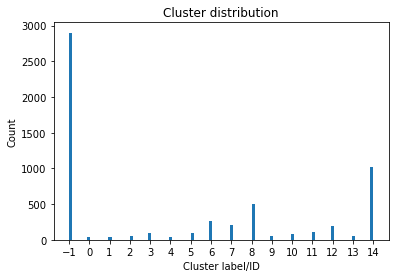

In [12]:
plt.hist(cluster_assignments, bins=100)
plt.xticks(range(-1, n_clusters))
plt.title('Cluster distribution')
plt.ylabel('Count')
plt.xlabel('Cluster label/ID')

Now process the quotes:

In [13]:
quotes = []

def process_chunk(chunk):
        print(f'Processing chunk')
        quotes.append(chunk[['quoteID', 'quotation']])      

with pd.read_json(QUOTES_PATH, lines=True, compression='bz2', chunksize=1000000) as df_reader:
    for chunk in df_reader:
        process_chunk(chunk)
        
quotes = pd.concat(quotes)

Processing chunk
Processing chunk
Processing chunk
Processing chunk
Processing chunk
Processing chunk


In [14]:
# Create dictionary {quoteID -> quotation}
quotes_dict = dict(quotes.values)

#### Semantic analysis

In [15]:
# Group quote IDs by journal
by_journal = clean_quotes.groupby('journal')

In [ ]:
journal_stats = []
for i, journal in enumerate(by_journal.groups.keys()):
    # Fetch i-th journal quote IDs
    jrnl_quotes = by_journal.get_group(journal)
    # Use the {ID -> quote} dict to obtain quotations
    qs = [quotes_dict[q] for q in jrnl_quotes.quoteID.values]
    # Join all quotes to perform semantic analysis in one go on all quotations
    qs = '\n'.join(qs)
    # Semantic analysis
    q_stats = lexicon.analyze(qs, categories=interesting_categories, normalize=True)
    # Add to list which will be converted into a dataframe at the end (computationally faster)
    journal_stats.append(pd.DataFrame(q_stats, index=[journal]))
    # Print progress (5734 total journals)
    print(f'Journal {i}/5734 :  {journal}')

In [17]:
# Convert to dataframe
journals = pd.concat(journal_stats)
journals['cluster_id'] = journals.apply(lambda row: cluster_dict[row.name], axis=1)
journals

,money,health,government,leisure,technology,cinema_television,tourism,journalism,banking,social_media,...,fun,traveling,fashion,economics,politics,philosophy,law,feminine,beauty,cluster_id
1011now.com,0.005275,0.004946,0.005605,0.001649,0.002308,0.000495,0.000989,0.000659,0.003132,0.001484,...,0.000659,0.005605,0.000659,0.004451,0.006264,0.000495,0.004616,0.000330,0.000989,-1.0
1070thefan.com,0.001892,0.001576,0.000315,0.000946,0.000315,0.000000,0.000631,0.000631,0.000000,0.000000,...,0.002522,0.002837,0.000000,0.001576,0.001261,0.000315,0.000000,0.000631,0.000000,-1.0
107jamz.com,0.002170,0.001184,0.001184,0.002762,0.000395,0.000987,0.000592,0.000789,0.002368,0.001381,...,0.002960,0.002170,0.001184,0.002170,0.002762,0.000197,0.001579,0.001381,0.001381,6.0
10news.com,0.004169,0.004796,0.004279,0.001881,0.002509,0.000443,0.000996,0.000738,0.002619,0.002029,...,0.001291,0.003136,0.000848,0.004316,0.007415,0.000406,0.003726,0.000516,0.000553,14.0
1130thetiger.com,0.000592,0.002960,0.001184,0.003552,0.002368,0.002368,0.000000,0.000592,0.001184,0.002960,...,0.004737,0.003552,0.000592,0.000592,0.005921,0.000000,0.001776,0.000000,0.002368,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zalebs.com,0.002714,0.000000,0.002714,0.002714,0.000000,0.001357,0.002714,0.001357,0.002714,0.002714,...,0.002714,0.009498,0.001357,0.000000,0.002714,0.001357,0.004071,0.004071,0.000000,-1.0
zawya.com,0.005466,0.003305,0.010828,0.001341,0.005801,0.000173,0.002126,0.000994,0.004923,0.001410,...,0.000982,0.004414,0.000578,0.011059,0.010204,0.001271,0.005073,0.000462,0.000901,14.0
zdnet.com,0.005813,0.002236,0.008432,0.001278,0.019610,0.000256,0.001533,0.001086,0.006196,0.002683,...,0.000639,0.003833,0.001150,0.009645,0.008943,0.000894,0.006068,0.000575,0.000511,-1.0
zeibiz.com,0.000000,0.003425,0.000000,0.003425,0.003425,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.003425,0.003425,0.003425,0.000000,0.000000,0.000000,0.000000,0.006849,0.006849,6.0


In [18]:
# Save dataset
journals.to_csv('../datasets/journals-semantic.csv.bz2', compression='bz2')

In [19]:
journals.describe()

,money,health,government,leisure,technology,cinema_television,tourism,journalism,banking,social_media,...,fun,traveling,fashion,economics,politics,philosophy,law,feminine,beauty,cluster_id
count,5734.000000,5734.000000,5734.000000,5734.000000,5734.000000,5734.000000,5734.000000,5734.000000,5734.000000,5734.000000,...,5734.000000,5734.000000,5734.000000,5734.000000,5734.000000,5734.000000,5734.000000,5734.000000,5734.000000,5734.000000
mean,0.003926,0.003148,0.005019,0.002021,0.003494,0.000468,0.000977,0.001048,0.003044,0.001318,...,0.001974,0.003349,0.000749,0.005469,0.006604,0.000971,0.003428,0.000838,0.000956,4.377747
std,0.003897,0.003699,0.004236,0.001846,0.005077,0.001276,0.001424,0.001315,0.003551,0.001314,...,0.002191,0.002304,0.001228,0.005408,0.004946,0.001355,0.003255,0.001400,0.001296,6.098068
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000
25%,0.001757,0.001085,0.002025,0.000994,0.001058,0.000000,0.000000,0.000241,0.001064,0.000583,...,0.000565,0.002397,0.000000,0.002300,0.003057,0.000216,0.001055,0.000000,0.000196,-1.000000
50%,0.003148,0.002566,0.004520,0.001752,0.002043,0.000161,0.000735,0.000792,0.002240,0.001164,...,0.001411,0.003171,0.000521,0.003927,0.006114,0.000715,0.003021,0.000629,0.000712,-1.000000
75%,0.004800,0.004007,0.006807,0.002645,0.003615,0.000436,0.001223,0.001364,0.003719,0.001650,...,0.002705,0.003961,0.000856,0.006780,0.008938,0.001165,0.004805,0.001058,0.001149,10.000000
max,0.064516,0.067227,0.062827,0.030151,0.087137,0.050000,0.035294,0.022727,0.064516,0.016393,...,0.025126,0.040000,0.040000,0.067797,0.054152,0.023256,0.058140,0.050000,0.029851,14.000000


In [20]:
# Group information by cluster
cluster_semantics = journals.groupby('cluster_id').describe(percentiles=[])
cluster_semantics

money                                               health  \
             count      mean       std  min       50%       max   count   
cluster_id                                                                
-1.0        2900.0  0.003929  0.004437  0.0  0.002910  0.064516  2900.0   
 0.0          33.0  0.003321  0.003257  0.0  0.002569  0.017679    33.0   
 1.0          39.0  0.002259  0.002070  0.0  0.001662  0.010657    39.0   
 2.0          49.0  0.004172  0.002241  0.0  0.004008  0.009332    49.0   
 3.0          91.0  0.002143  0.001778  0.0  0.001909  0.011688    91.0   
 4.0          34.0  0.003355  0.007466  0.0  0.001510  0.043478    34.0   
 5.0          93.0  0.001961  0.002577  0.0  0.001417  0.020930    93.0   
 6.0         263.0  0.001529  0.001678  0.0  0.001283  0.015385   263.0   
 7.0         206.0  0.005116  0.003635  0.0  0.004721  0.027894   206.0   
 8.0         504.0  0.004918  0.003502  0.0  0.003601  0.030303   504.0   
 9.0          54.0  0.003821  0.002824  0.0  0.003722  0.012410    54.0   
 10.0         78.0  0.003963  0.002768  0.0  0.003763  0.012072    78.0   
 11.0        114.0  0.003580  0.002550  0.0  0.002945  0.013247   114.0   
 12.0        195.0  0.004341  0.002601  0.0  0.003574  0.019544   195.0   
 13.0         55.0  0.005237  0.003617  0.0  0.004693  0.014493    55.0   
 14.0       1026.0  0.004126  0.003105  0.0  0.003259  0.026667  1026.0   

                                     ...  feminine                           \
                mean       std  min  ...       std  min       50%       max   
cluster_id                           ...                                      
-1.0        0.003182  0.004544  0.0  ...  0.001566  0.0  0.000457  0.050000   
 0.0        0.000959  0.001432  0.0  ...  0.000774  0.0  0.000256  0.003708   
 1.0        0.002794  0.002159  0.0  ...  0.000611  0.0  0.000411  0.002973   
 2.0        0.002854  0.002896  0.0  ...  0.000708  0.0  0.000586  0.003254   
 3.0        0.001250  0.001150  0.0  ...  0.000601  0.0  0.000376  0.004219   
 4.0        0.000647  0.000664  0.0  ...  0.001099  0.0  0.001006  0.003922   
 5.0        0.001081  0.001397  0.0  ...  0.001407  0.0  0.000787  0.008439   
 6.0        0.001568  0.001619  0.0  ...  0.002771  0.0  0.001795  0.040000   
 7.0        0.004148  0.002150  0.0  ...  0.000759  0.0  0.000799  0.005137   
 8.0        0.003103  0.002651  0.0  ...  0.000701  0.0  0.000580  0.007752   
 9.0        0.006120  0.005534  0.0  ...  0.000880  0.0  0.000425  0.004107   
 10.0       0.004219  0.003316  0.0  ...  0.000755  0.0  0.000657  0.003268   
 11.0       0.002266  0.001201  0.0  ...  0.000805  0.0  0.000604  0.005000   
 12.0       0.003666  0.002566  0.0  ...  0.000763  0.0  0.000893  0.005634   
 13.0       0.003931  0.003053  0.0  ...  0.000780  0.0  0.000331  0.003831   
 14.0       0.003535  0.002249  0.0  ...  0.000784  0.0  0.000796  0.011450   

            beauty                                               
             count      mean       std  min       50%       max  
cluster_id                                                       
-1.0        2900.0  0.000976  0.001461  0.0  0.000630  0.029851  
 0.0          33.0  0.001104  0.000976  0.0  0.000848  0.002985  
 1.0          39.0  0.001078  0.001131  0.0  0.000857  0.005865  
 2.0          49.0  0.000989  0.001097  0.0  0.000747  0.006158  
 3.0          91.0  0.000667  0.000544  0.0  0.000706  0.002629  
 4.0          34.0  0.000633  0.001038  0.0  0.000122  0.003922  
 5.0          93.0  0.000799  0.001284  0.0  0.000539  0.008065  
 6.0         263.0  0.001965  0.002095  0.0  0.001680  0.026490  
 7.0         206.0  0.000919  0.000575  0.0  0.000884  0.004425  
 8.0         504.0  0.000993  0.000974  0.0  0.000954  0.010482  
 9.0          54.0  0.000897  0.001530  0.0  0.000702  0.010870  
 10.0         78.0  0.000925  0.001281  0.0  0.000766  0.007157  
 11.0        114.0  0.000874  0.000600  0.0  0.000814  0.003506  
 12.0        195.0  0.000699 

In [21]:
# Save dataset
cluster_semantics.to_csv('../datasets/clusters-semantic.csv.bz2', compression='bz2')

#### Normalized
The normalized data helps to show the importance of the observed categories **with respect to themselves**.

In [22]:
# Before normalization
np.linalg.norm(journals[interesting_categories], axis=1)

array([0.02298566, 0.01185053, 0.01311079, ..., 0.03441182, 0.01779504,
       0.03209253])

In [23]:
normed_journals = journals.copy()
norms_matrix = np.repeat(np.linalg.norm(journals[interesting_categories], axis=1).reshape(5734, 1), 37, axis=1)
normed_journals[interesting_categories] = normed_journals[interesting_categories] / norms_matrix
# After normalization
np.linalg.norm(normed_journals[interesting_categories], axis=1)

array([1., 1., 1., ..., 1., 1., 1.])

In [24]:
normed_journals.describe()

,money,health,government,leisure,technology,cinema_television,tourism,journalism,banking,social_media,...,fun,traveling,fashion,economics,politics,philosophy,law,feminine,beauty,cluster_id
count,5726.000000,5726.000000,5726.000000,5726.000000,5726.000000,5726.000000,5726.000000,5726.000000,5726.000000,5726.000000,...,5726.000000,5726.000000,5726.000000,5726.000000,5726.000000,5726.000000,5726.000000,5726.000000,5726.000000,5734.000000
mean,0.161815,0.143696,0.210964,0.099720,0.134387,0.024840,0.043393,0.047841,0.119988,0.062550,...,0.101325,0.158028,0.033914,0.213720,0.288365,0.044492,0.149551,0.043710,0.046644,4.377747
std,0.100526,0.128227,0.132275,0.081787,0.132935,0.058331,0.047555,0.050123,0.085290,0.055499,...,0.103272,0.090420,0.043258,0.129254,0.177173,0.049886,0.111710,0.056638,0.055057,6.098068
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000
25%,0.094636,0.048516,0.103914,0.040765,0.056745,0.000000,0.000000,0.012229,0.059131,0.025206,...,0.021264,0.102598,0.000000,0.124899,0.151950,0.009468,0.053916,0.000000,0.008292,-1.000000
50%,0.163990,0.129792,0.220428,0.083951,0.105875,0.007923,0.037539,0.041143,0.120844,0.059007,...,0.069046,0.162234,0.026958,0.212488,0.287860,0.037359,0.146398,0.030889,0.035666,-1.000000
75%,0.213962,0.204939,0.304849,0.150329,0.155229,0.023902,0.058793,0.067870,0.162745,0.086311,...,0.157709,0.206829,0.042723,0.280048,0.411288,0.059974,0.227266,0.058769,0.060664,10.000000
max,1.000000,0.984732,0.744208,0.685994,0.911322,0.894427,0.487065,0.670820,0.640513,0.707107,...,0.755929,0.707107,0.696311,0.816497,1.000000,0.629844,0.714286,0.707107,0.707107,14.000000


In [25]:
# Save dataset
normed_journals.to_csv('../datasets/journals-semantic-NORMED.csv.bz2', compression='bz2')

In [26]:
# Group information by cluster
cluster_semantics_normed = normed_journals.groupby('cluster_id').describe(percentiles=[])
cluster_semantics_normed

money                                               health  \
             count      mean       std  min       50%       max   count   
cluster_id                                                                
-1.0        2892.0  0.149020  0.108654  0.0  0.141461  1.000000  2892.0   
 0.0          33.0  0.132096  0.090264  0.0  0.118005  0.484595    33.0   
 1.0          39.0  0.115122  0.078639  0.0  0.096815  0.300753    39.0   
 2.0          49.0  0.186105  0.083612  0.0  0.199889  0.360028    49.0   
 3.0          91.0  0.108358  0.067666  0.0  0.104676  0.377964    91.0   
 4.0          34.0  0.117446  0.102610  0.0  0.094245  0.333333    34.0   
 5.0          93.0  0.098862  0.097411  0.0  0.090098  0.557086    93.0   
 6.0         263.0  0.093185  0.065519  0.0  0.092180  0.348695   263.0   
 7.0         206.0  0.211608  0.077565  0.0  0.214664  0.555556   206.0   
 8.0         504.0  0.211114  0.084018  0.0  0.208530  0.571429   504.0   
 9.0          54.0  0.144519  0.095454  0.0  0.150441  0.372104    54.0   
 10.0         78.0  0.166812  0.094770  0.0  0.170990  0.402921    78.0   
 11.0        114.0  0.163430  0.076058  0.0  0.162829  0.401915   114.0   
 12.0        195.0  0.192639  0.073053  0.0  0.185951  0.426401   195.0   
 13.0         55.0  0.207019  0.119316  0.0  0.217643  0.506024    55.0   
 14.0       1026.0  0.186814  0.079478  0.0  0.180819  0.707107  1026.0   

                                     ...  feminine                           \
                mean       std  min  ...       std  min       50%       max   
cluster_id                           ...                                      
-1.0        0.134109  0.145198  0.0  ...  0.057360  0.0  0.020289  0.707107   
 0.0        0.040287  0.058054  0.0  ...  0.030532  0.0  0.010713  0.138086   
 1.0        0.149019  0.107484  0.0  ...  0.029567  0.0  0.024204  0.108306   
 2.0        0.132042  0.120807  0.0  ...  0.031703  0.0  0.030151  0.141263   
 3.0        0.068558  0.060414  0.0  ...  0.028806  0.0  0.022199  0.188982   
 4.0        0.043648  0.056102  0.0  ...  0.058188  0.0  0.066866  0.196116   
 5.0        0.057119  0.069391  0.0  ...  0.066615  0.0  0.048095  0.316228   
 6.0        0.104609  0.095038  0.0  ...  0.096712  0.0  0.129681  0.500000   
 7.0        0.189286  0.086593  0.0  ...  0.046499  0.0  0.035559  0.316158   
 8.0        0.151917  0.108083  0.0  ...  0.029455  0.0  0.027854  0.271607   
 9.0        0.244985  0.201760  0.0  ...  0.047363  0.0  0.017062  0.245256   
 10.0       0.185737  0.127841  0.0  ...  0.039674  0.0  0.028131  0.162221   
 11.0       0.115641  0.055656  0.0  ...  0.038612  0.0  0.032062  0.225744   
 12.0       0.170971  0.096146  0.0  ...  0.035979  0.0  0.046859  0.248069   
 13.0       0.163070  0.118459  0.0  ...  0.028761  0.0  0.016829  0.140567   
 14.0       0.177424  0.097813  0.0  ...  0.040171  0.0  0.043284  0.600000   

            beauty                                               
             count      mean       std  min       50%       max  
cluster_id                                                       
-1.0        2892.0  0.044514  0.060069  0.0  0.029150  0.707107  
 0.0          33.0  0.053944  0.048719  0.0  0.046958  0.168805  
 1.0          39.0  0.064017  0.074630  0.0  0.048679  0.377964  
 2.0          49.0  0.045907  0.043490  0.0  0.034166  0.196116  
 3.0          91.0  0.036578  0.029553  0.0  0.040191  0.153093  
 4.0          34.0  0.035638  0.053118  0.0  0.007296  0.191565  
 5.0          93.0  0.041810  0.057374  0.0  0.034221  0.333333  
 6.0         263.0  0.121631  0.079673  0.0  0.120800  0.512148  
 7.0         206.0  0.044076  0.031129  0.0  0.040400  0.285536  
 8.0         504.0  0.048313  0.037810  0.0  0.054453  0.327089  
 9.0          54.0  0.038158  0.062888  0.0  0.026397  0.417029  
 10.0         78.0  0.044279  0.059345  0.0  0.034796  0.342381  
 11.0        114.0  0.045675  0.032367  0.0  0.044959  0.207316  
 12.0        195.0  0.033247 

In [27]:
# Save dataset
cluster_semantics_normed.to_csv('../datasets/clusters-semantic-NORMED.csv.bz2', compression='bz2')